# Vehicle Tire Condition Detection using MobileNet_v2


The goal of this project is to develop a machine learning model capable of detecting the condition of vehicle tires. The model will classify tire images into two categories: "perfect" and "defective". This binary classification problem aims to enhance vehicle safety by providing a reliable and efficient method for identifying tire defects, which are critical for preventing accidents and ensuring road safety.

According to the National Highway Traffic Safety Administration (NHTSA), tire-related crashes contribute to approximately 11,000 traffic accidents annually in the United States. Proper tire maintenance and timely detection of tire defects can significantly reduce these numbers and improve overall vehicle safety.

## Project Overview

The primary objective of this project is to enhance vehicle safety by providing a reliable method for identifying tire defects. Tire-related crashes are a significant concern, and timely detection of defects can prevent accidents and ensure road safety.

## Key Features

- **Binary Classification**: Classifies tire images into "perfect" and "defective".
- **Transfer Learning**: Utilizes MobileNet_v2 for efficient and accurate predictions.
- **Real-Time Detection**: Provides quick and reliable classification results.

## Dataset

The dataset consists of images of vehicle tires categorized into "perfect" and "defective". The data is split into training, validation, and test sets.
Dataset was obtained from roboflow website credit for dataset is due to contributor as roboflow

## Model Architecture

The model is built using MobileNet_v2 as the base model, with additional custom layers for the binary classification task.

## Importing Libraries

In this section, we import the necessary libraries for data manipulation, model building, training, and evaluation. We also ensure that TensorFlow can manage GPU memory growth to prevent memory issues.
- We have used wandb for tracking our experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import wandb
from wandb.integration.keras import WandbMetricsLogger
from wandb.integration.keras import WandbModelCheckpoint
from wandb.integration.keras import WandbEvalCallback

Config for wandb to track and to be used 

In [3]:
# Define a dictionary named configs with various configuration settings for the model
configs = dict(
    # Set the number of classes to 1 (e.g., for binary classification)
    num_classes = 1,
    
    # Set the batch size to 32 (number of samples per gradient update)
    batch_size = 32,
    
    # Set the image size to 224 (both width and height, assuming square images)
    image_size = 224,
    
    # Set the number of image channels to 3 (e.g., for RGB images)
    image_channels = 3,
    
    # Set the patience for early stopping to 3 (number of epochs with no improvement after which training will be stopped)
    earlystopping_patience = 3,
    
    # Set the learning rate for the optimizer to 1e-3 (0.001)
    learning_rate = 1e-3,
    
    # Set the initial number of epochs for training to 8
    initial_epochs = 8
)


## Loading Data

This section covers loading the dataset using the image_dataset_from_directory. We define the paths for the training, validation, and test datasets Batch Size and Image size .

In [4]:
# Define a function to load data from directories
def load_data(train_dir, val_dir, test_dir, IMG_SIZE, BATCH_SIZE):
    # Load the training dataset from the specified directory, shuffling the data and setting the batch size and image size
    train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)
    # Load the validation dataset from the specified directory, shuffling the data and setting the batch size and image size
    validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                     
                                                                     batch_size=BATCH_SIZE,
                                                                     image_size=IMG_SIZE)
    # Load the test dataset from the specified directory, setting the batch size and image size (no shuffling)
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)
    # Return the loaded datasets
    return train_dataset, validation_dataset, test_dataset

# Extract the batch size from the configs dictionary
BATCH_SIZE = configs["batch_size"]
# Extract the image size from the configs dictionary and convert it to a tuple
IMG_SIZE = (configs["image_size"], configs["image_size"])

# Define the directory path for the training dataset
train_directory = 'dataset/train'
# Define the directory path for the validation dataset
valid_directory = 'dataset/valid'
# Define the directory path for the test dataset
test_directory = 'dataset/test'

# Call the load_data function with the specified directories, image size, and batch size
# Store the returned datasets in train_dataset, validation_dataset, and test_dataset variables
train_dataset, validation_dataset, test_dataset = load_data(train_directory, valid_directory, test_directory, IMG_SIZE, BATCH_SIZE)


Found 4411 files belonging to 2 classes.


2024-07-08 15:04:40.489848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 15:04:40.735597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 15:04:40.738695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 163 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


Lets make sure our class names are same in all datasets and carry same order .

In [5]:
# Extract the class names from the train dataset and store them in the variable train_dataset_class_names
train_dataset_class_names = train_dataset.class_names

# Extract the class names from the test dataset and store them in the variable test_dataset_class_names
test_dataset_class_names = test_dataset.class_names

# Extract the class names from the validation dataset and store them in the variable validation_dataset_class_names
validation_dataset_class_names = validation_dataset.class_names

# Print the class names from the train dataset
print(f"Class names in train dataset: {train_dataset_class_names}")

# Print the class names from the test dataset
print(f"Class names in test dataset: {test_dataset_class_names}")

# Print the class names from the validation dataset
print(f"Class names in validation dataset: {validation_dataset_class_names}")


Class names in train dataset: ['defective', 'perfect']
Class names in test dataset: ['defective', 'perfect']
Class names in validation dataset: ['defective', 'perfect']


## Raw data logging into weights and Biases (wandb)
Belwo we will add our train , validation and test raw dataset into wandb one by one.

In [6]:
# Define the project name for wandb
PROJECT = "Vehicle-Tyres-Health-Condition-Classification"
# Define the team name for wandb
TEAM = "teamarsalan"

In [7]:
# Define a function to add raw data to a Weights and Biases (wandb) table
def addRawdata(dataset):
    # Initialize a wandb Table with columns "Images" and "label"
    table = wandb.Table(columns=["Images", "label"])
    
    # Iterate over the dataset, which contains batches of images and labels
    for images, labels in dataset:
        # Iterate over each image and label in the current batch
        for i in range(images.shape[0]):
            # Get the i-th image from the current batch
            image = images[i]
            # Get the i-th label from the current batch
            label = labels[i]
            # Add the image and label to the table
            table.add_data(wandb.Image(image), label)
    
    # Return the populated table
    return table


In [8]:
#Upload train raw dataset to wandb
# Initialize a new wandb run with the specified project and team names, and set the job type to "upload"
run = wandb.init(project=PROJECT, entity=TEAM, job_type="upload")
# Create a new wandb Artifact named "Train_raw_data" with the type "raw_data"
raw_data_at = wandb.Artifact("Train_raw_data", type="raw_data")
# Add the directory "dataset/train" to the artifact under the name "Train_raw_data"
raw_data_at.add_dir(train_directory, name="Train_raw_data")

# Call the addRawdata function with the train_dataset and store the returned table in the variable table
table = addRawdata(train_dataset)
# Add the table to the artifact under the name "Train_raw_data"
raw_data_at.add(table, "Train_raw_data")

# Log the artifact to the current wandb run
run.log_artifact(raw_data_at)
# Finish the wandb run, ensuring all data is logged and the run is properly closed
run.finish()

wandb: Currently logged in as: arsalanzabeeb (teamarsalan). Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/train)... Done. 2.7s
2024-07-06 23:29:44.345294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Upload Validation raw dataset to wandb
# Initialize a new wandb run with the specified project and team names, and set the job type to "upload"
run = wandb.init(project=PROJECT, entity=TEAM, job_type="upload")

# Create a new wandb Artifact named "Validation_raw_data" with the type "raw_data"
raw_data_at = wandb.Artifact("Validation_raw_data", type="raw_data")

# Add the directory specified by valid_directory to the artifact under the name "Validation_raw_data"
raw_data_at.add_dir(valid_directory, name="Validation_raw_data")

# Call the addRawdata function with the validation_dataset and store the returned table in the variable table
table = addRawdata(validation_dataset)

# Add the table to the artifact under the name "Validation_raw_data"
raw_data_at.add(table, "Validation_raw_data")

# Log the artifact to the current wandb run
run.log_artifact(raw_data_at)

# Finish the wandb run, ensuring all data is logged and the run is properly closed
run.finish()



wandb: Adding directory to artifact (/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/valid)... Done. 0.2s
2024-07-06 23:40:02.543554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Upload Test raw dataset to wandb
# Initialize a new wandb run with the specified project and team names, and set the job type to "upload"
run = wandb.init(project=PROJECT, entity=TEAM, job_type="upload")

# Create a new wandb Artifact named "Test_raw_data" with the type "raw_data"
raw_data_at = wandb.Artifact("Test_raw_data", type="raw_data")

# Add the directory specified by test_directory to the artifact under the name "Test_raw_data"
raw_data_at.add_dir(test_directory, name="Test_raw_data")

# Call the addRawdata function with the test_dataset and store the returned table in the variable table
table = addRawdata(test_dataset)

# Add the table to the artifact under the name "Test_raw_data"
raw_data_at.add(table, "Test_raw_data")

# Log the artifact to the current wandb run
run.log_artifact(raw_data_at)

# Finish the wandb run, ensuring all data is logged and the run is properly closed
run.finish()



wandb: Adding directory to artifact (/home/arsalan/DATA/github_files/keras_cv/TyreQualityPrediction/dataset/test)... Done. 0.1s
2024-07-06 23:41:48.521679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Lets take a look at some of examples to get some idea .

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


2024-07-07 00:34:27.423706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


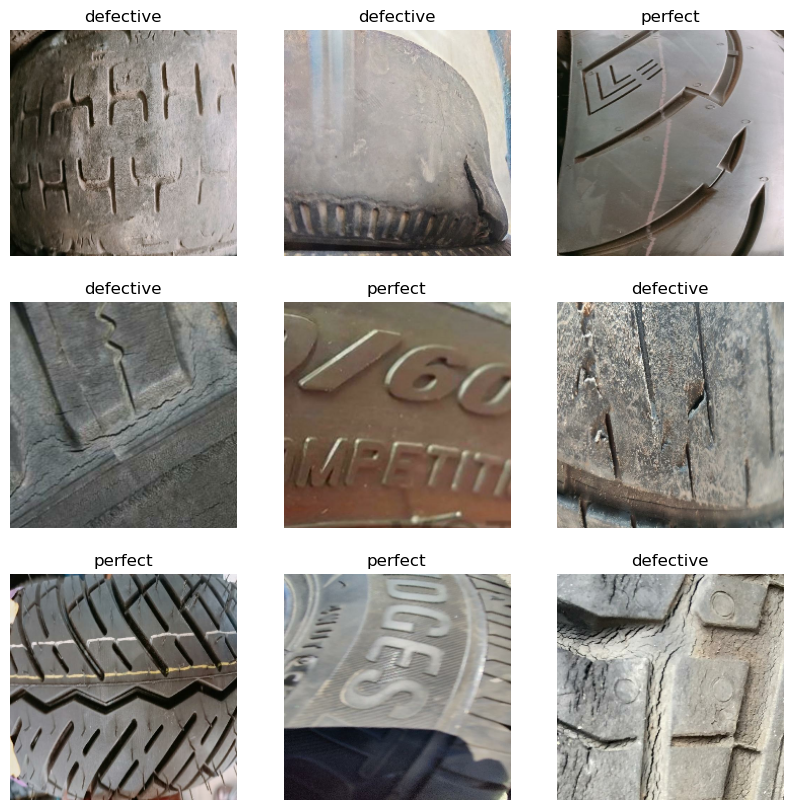

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)  
    print("Label batch shape:", labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset_class_names[labels[i]])
        plt.axis("off")
        

## Optimizing Data Pipeline

To optimize the data input pipeline, we use TensorFlow's `AUTOTUNE` feature. This allows the runtime to automatically determine the best parameters for data loading and preprocessing. By caching the dataset and prefetching the data with `AUTOTUNE`, we ensure that the data pipeline can keep up with the training loop, thereby improving performance. 
As we have less data so augementation would be good idea to get some more examples to train on. 
We Will use `Sequential` keras model composed of 2 layers to augment our data:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`
These two seems much logical at this point as people can take pictures of their tyres with different angles .


In [9]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
    ])
    return data_augmentation

# Initialize the data augmentation layer
augmentation_layer = data_augmenter()

# Define a function to apply the augmentation
def augment(image, label):
    image = augmentation_layer(image)
    return image, label



In [10]:
# Assume train_dataset, validation_dataset, and test_dataset are already defined
AUTOTUNE = tf.data.AUTOTUNE

# Apply the augmentation only to the training dataset
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# The validation and test datasets do not need augmentation
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Take a look at how an image from the training set has been augmented with simple transformations:


2024-07-07 00:34:39.083494: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-07 00:34:40.370892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


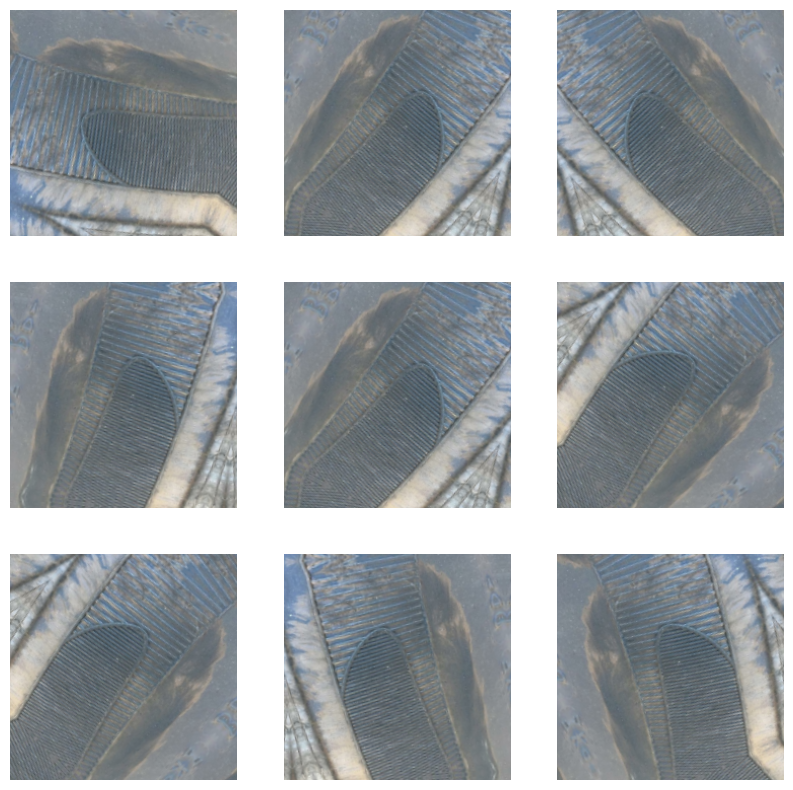

In [11]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
    

Next, we will start working on building our model . First thing which we need to do for the MobileNet application in TensorFlow, is normalize input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

## Model Definition

In this section, we define the model architecture using MobileNet_v2 as the base model. We add custom layers on top for our specific binary classification task. MobileNet_v2 is a lightweight deep learning model pre-trained on the ImageNet dataset, making it ideal for transfer learning.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = (configs["image_size"], configs["image_size"], configs["image_channels"])
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
def model(inputshape, preprocess_input,base_model):
    # Define the input layer with the specified input shape
    inputs = tf.keras.Input(shape=inputshape)
    
    # Preprocess the inputs using the MobileNetV2 preprocessing function
    x = preprocess_input(inputs)
    
    # Pass the preprocessed inputs through the base model (MobileNetV2)
    x = base_model(x, training=False)
    
    # Apply global average pooling to reduce the spatial dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Apply a dropout layer with a 20% dropout rate for regularization
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Add a dense output layer with a single neuron and sigmoid activation function for binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model by specifying the inputs and outputs
    model = tf.keras.Model(inputs, outputs)
    
    # Return the constructed model
    return model



# Create the model with the specified input shape and set the base model layers as non-trainable
model = model(IMG_SHAPE,preprocess_input,base_model)

In [15]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training the Model

This section involves compiling the model, defining callbacks, and training the model on the training dataset while validating on the validation dataset. We use the Adam optimizer and Binary cross-entropy loss function.

In [16]:
callbacks = [
    # ModelCheckpoint callback saves the model after every epoch.
    # The filename includes the accuracy, validation accuracy, loss, and validation loss.
    tf.keras.callbacks.ModelCheckpoint(
        'model_accuracy:{accuracy:0.2f}_Val_acc:{val_accuracy:0.2f}_loss:{loss:0.2f}_Val_loss:{val_loss:0.2f}.keras', 
        save_best_only=True,  # Save only the best model based on the monitored metric.
        monitor='val_loss'  # Monitor the validation accuracy to determine the best model.
    ),
    # EarlyStopping callback stops training when the monitored metric has stopped improving.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor the validation accuracy.
        patience= 5,  # Number of epochs with no improvement after which training will be stopped.
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric.
    )
]

In [17]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type="Training",
    config = configs
)


wandb: Currently logged in as: arsalanzabeeb (teamarsalan). Use `wandb login --relogin` to force relogin


In [18]:
# corrected code 

class WandbClfEvalCallback(WandbEvalCallback):
    def __init__(self, validloader, data_table_columns, pred_table_columns, num_samples=100):
        super().__init__(data_table_columns, pred_table_columns)
        
        # Take a fixed number of samples from the validation loader, converting it to a list for fixed iteration
        self.val_data = list(validloader.unbatch().take(num_samples))
        self.data_table_columns = data_table_columns
        self.pred_table_columns = pred_table_columns

    def add_ground_truth(self, logs=None):
        # Iterate over the fixed number of samples in the validation data
        for idx, (image, label) in enumerate(self.val_data):
            # Add each image and its corresponding label to the data table
            self.data_table.add_data(idx, wandb.Image(image.numpy()), int(label.numpy()))

    def add_model_predictions(self, epoch, logs=None):
        # Get predictions for the validation samples
        preds = self._inference()
        table_idxs = range(len(self.val_data))

        # Add predictions to the prediction table along with corresponding ground truth data
        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                idx,
                self.data_table.data[idx][1],  # Image
                self.data_table.data[idx][2],  # Ground truth label
                pred,  # Predicted label
            )

    def _inference(self):
        preds = []
        # Iterate over the fixed number of samples in the validation data
        for image, label in self.val_data:
            # Get model prediction for each image
            pred = self.model(tf.expand_dims(image, axis=0))
            binary_pred = (pred.numpy() > 0.5).astype(int)[0][0]
            preds.append(binary_pred)
        return preds


In [19]:
def compile_model(model, learning_rate):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

                  
def fit_model(model, train_dataset, validation_dataset, initial_epochs , callbacks):                  
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, 
                        callbacks= callbacks 
                       )
    return history

In [20]:
callbacks=[callbacks,
           WandbMetricsLogger(log_freq=10),
           WandbClfEvalCallback(
               validation_dataset,
               data_table_columns=["idx", "image", "ground_truth"],
               pred_table_columns=["epoch", "idx", "image", "ground_truth", "prediction"],
           ),
          ]
learning_rate = configs["learning_rate"]
initial_epochs = 10
compile_model(model, learning_rate)
history = fit_model(model, train_dataset, validation_dataset, initial_epochs ,callbacks)

2024-07-07 00:36:23.093074: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-07 00:36:23.097745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
wandb:   101 of 101 files downloaded.  


Epoch 1/10


I0000 00:00:1720280201.059388  122722 service.cc:145] XLA service 0xa67ff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720280201.059469  122722 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-07-07 00:36:41.264783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-07 00:36:42.167142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720280210.852248  122722 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
wandb: ERROR Unable to log learning rate.


138/138 ━━━━━━━━━━━━━━━━━━━━ 57s 298ms/step - accuracy: 0.7756 - loss: 0.4502 - val_accuracy: 0.9202 - val_loss: 0.2476
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9004 - loss: 0.2449 - val_accuracy: 0.9141 - val_loss: 0.2090
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.9219 - loss: 0.1976 - val_accuracy: 0.9141 - val_loss: 0.1928
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.9319 - loss: 0.1783 - val_accuracy: 0.9141 - val_loss: 0.1878
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.9362 - loss: 0.1670 - val_accuracy: 0.9141 - val_loss: 0.1776
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9440 - loss: 0.1535 - val_accuracy: 0.9264 - val_loss: 0.1727
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9432 - loss: 0.1546 - val_accuracy: 0.9141 - val_loss: 0.1656
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.9468 - loss: 0.1430 - val

In [21]:
wandb.finish()

batch/accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇█▇▇▇██▇▇██▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/loss,█▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▂▁▂▂▂▁▁▂▂▁▁▂▂
epoch/accuracy,▁▅▆▇▇█▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▄▃▃▂▂▂▁▁▁
epoch/val_accuracy,▆▄▄▄▄█▄▁▄▄
epoch/val_loss,█▅▄▃▂▂▁▂▁▂
batch/accuracy,0.94203
batch/batch_step,1390
batch/loss,0.14167


Lets Visualize what we have so far ....

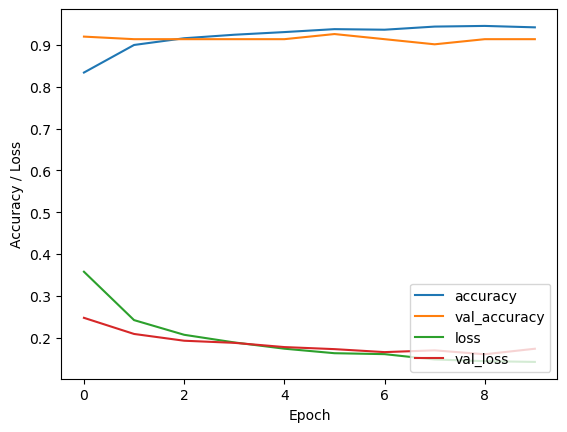

In [22]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

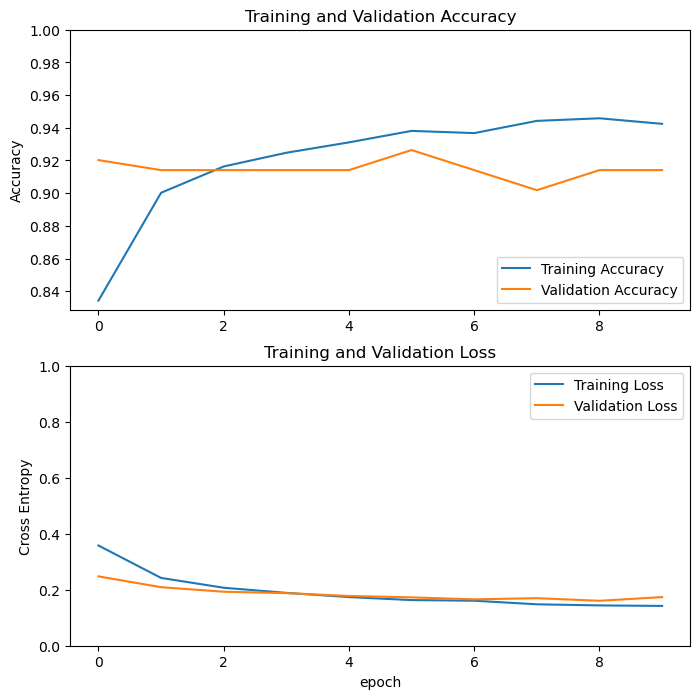

In [23]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    return acc ,val_acc,loss,val_loss

acc ,val_acc,loss,val_loss = plot_history(history)

Its looks like we are on right track as all these graphs show very nice convergence response . 
Lets now try fine tuning and see if we can get some more validaton accuraccy .

## Fine Tune 

First step is to set base mode trainable to True so we can train those weights as well.
Initally we will not train all layers but will choose 50 layers to train.

In [24]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


As there are 154 layers in our base model .
Lets freez all layers weights from 0 to 100-1 .

In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [26]:
model = model(IMG_SHAPE,preprocess_input,base_model)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2,564 (10.02 KB)

### Compile Model again with more smaller learning rate

In [27]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type = "Fine Tuning phase 2",
    config = configs
)


In [28]:
earning_rate = 1e-5
initial_epochs = 10
compile_model(model, learning_rate)

In [29]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 15  # Number of epochs for fine-tuning after initial training

# Calculate the total number of epochs for the entire training process
total_epochs = initial_epochs + fine_tune_epochs

# Define a function to fit the model with fine-tuning
def fit_model_finetune(train_dataset, validation_dataset, initial_epochs, total_epochs, callbacks):
    # Fit the model using the training dataset
    # Start training from the last completed epoch in the initial training phase
    fine_tune_history = model.fit(
        train_dataset,
        epochs=total_epochs,  # Train until the total number of epochs is reached
        initial_epoch=len(history.epoch),  # Continue training from the epoch where initial training stopped
        validation_data=validation_dataset,  # Use the validation dataset for validation
        callbacks=callbacks  # Use the specified callbacks for saving the model and early stopping
    )
    return fine_tune_history  # Return the training history of the fine-tuning phase

# Perform fine-tuning on the model using the training and validation datasets
fine_tune_history = fit_model_finetune(train_dataset, validation_dataset, initial_epochs, total_epochs, callbacks)


wandb:   101 of 101 files downloaded.  


Epoch 11/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 63s 307ms/step - accuracy: 0.8805 - loss: 0.3059 - val_accuracy: 0.8282 - val_loss: 0.6345
Epoch 12/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.9664 - loss: 0.0984 - val_accuracy: 0.8957 - val_loss: 0.9589
Epoch 13/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.9794 - loss: 0.0670 - val_accuracy: 0.8834 - val_loss: 1.4216
Epoch 14/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - accuracy: 0.9867 - loss: 0.0373 - val_accuracy: 0.8773 - val_loss: 1.7704
Epoch 15/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.9869 - loss: 0.0318 - val_accuracy: 0.9080 - val_loss: 1.2713


In [30]:
wandb.finish()

batch/accuracy,▁▃▄▅▅▅▅▅▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇███████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/loss,▆█▆▅▅▅▅▄▂▂▂▂▂▃▂▂▁▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
epoch/accuracy,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/loss,█▃▂▁▁
epoch/val_accuracy,▁▇▆▅█
epoch/val_loss,▁▃▆█▅
batch/accuracy,0.98879
batch/batch_step,2090
batch/loss,0.02901


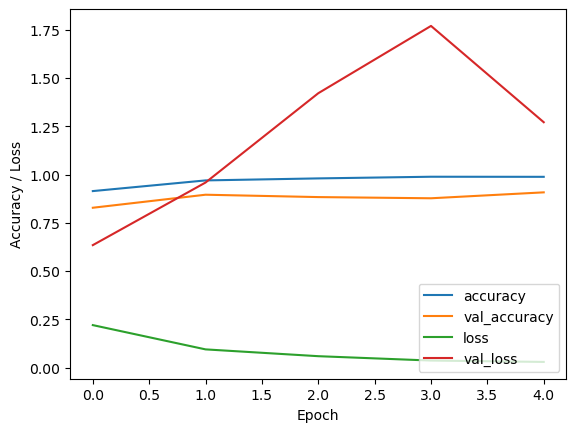

In [32]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(fine_tune_history)

In [33]:
acc += fine_tune_history.history['accuracy']
val_acc += fine_tune_history.history['val_accuracy']

loss += fine_tune_history.history['loss']
val_loss += fine_tune_history.history['val_loss']

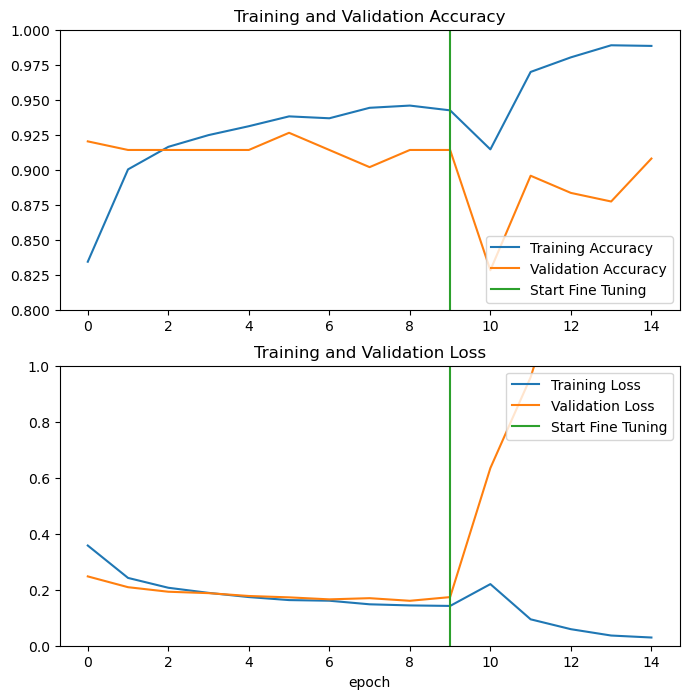

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### As we can see fine tunning had inverse impact on our data set . 
it seems that training further without finetuning would bring much batter results . So we will not use fine tuned models for further . Infact we will use our previously saved best model with validation accuracy of 93% and val loss of 17% , training accuracy of 94% and training loss of 16% .

In [35]:
base_model.trainable = False 

In [36]:
from tensorflow.keras.models import load_model


In [42]:
model_path = 'model_accuracy:0.94_Val_acc:0.93_loss:0.16_Val_loss:0.17.keras'

In [43]:
loaded_best_model = load_model(model_path)

In [45]:
wandb.finish()

batch/accuracy,█▂▁▁▁▁▁█▃▃▂▂▂▂▅▄▂▂▂▂█▃▂▂▂▂▂▄▃▃▂▃▃█▃▄▃▃▃▃
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/loss,▂▇█████▁▆▇▇▇▇▇▅▅▇▇▇▇▁▆▆▆▆▆▇▄▅▅▆▆▆▁▅▆▆▆▆▆
epoch/accuracy,▁▁▄▄▅▅▆▆▇▇██
epoch/epoch,▁▁▂▂▄▄▅▅▇▇██
epoch/loss,██▆▆▅▅▃▃▂▂▁▁
epoch/val_accuracy,██▆▆▁▁▆▆▁▁▁▁
epoch/val_loss,▃▃▄▄▅▅▁▁▇▇██
batch/accuracy,0.95157
batch/batch_step,830
batch/loss,0.12777


In [46]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type="Initial model's further Training",
    config = configs
)

In [47]:
def compile_model(model, learning_rate):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

                  
def fit_model(model, train_dataset, validation_dataset, initial_epochs , callbacks):                  
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, 
                        callbacks= callbacks 
                       )
    return history


In [48]:
callbacks=[callbacks,
           WandbMetricsLogger(log_freq=10),
           WandbClfEvalCallback(
               validation_dataset,
               data_table_columns=["idx", "image", "ground_truth"],
               pred_table_columns=["epoch", "idx", "image", "ground_truth", "prediction"],
           ),
          ]
learning_rate = 1e-6 # setting much smaller learning rate for better convergence
initial_epochs = 10
compile_model(loaded_best_model, learning_rate)
loaded_model_history = fit_model(loaded_best_model, train_dataset, validation_dataset, initial_epochs ,callbacks)

2024-07-07 01:04:52.024575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
wandb:   101 of 101 files downloaded.  
wandb:   101 of 101 files downloaded.  
wandb:   101 of 101 files downloaded.  


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 63s 405ms/step - accuracy: 0.9481 - loss: 0.1387 - val_accuracy: 0.9264 - val_loss: 0.1723
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 48s 346ms/step - accuracy: 0.9517 - loss: 0.1368 - val_accuracy: 0.9264 - val_loss: 0.1720
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 50s 363ms/step - accuracy: 0.9503 - loss: 0.1402 - val_accuracy: 0.9264 - val_loss: 0.1716
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 346ms/step - accuracy: 0.9507 - loss: 0.1405 - val_accuracy: 0.9264 - val_loss: 0.1713
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 378ms/step - accuracy: 0.9456 - loss: 0.1429 - val_accuracy: 0.9202 - val_loss: 0.1709


In [50]:
wandb.finish()

batch/accuracy,█▃▂▂▂▁▁▁█▄▃▂▂▂▂▁█▃▂▂▂▂▁▁▄▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁
batch/batch_step,▃▁▁▁▇▇▇▃▃▃▁▁▁▇▇▇▃▃▃▂▂▂███▄▄▄▂▂▂███▄▄▄▂▂▂
batch/loss,▁▅▇▇▇███▂▆▇▇████▁▇█▇████▆▇█▇█▇██▆▇██████
epoch/accuracy,▁▁▁▇▇▇▅▅▅███▃▃▃
epoch/epoch,▁▁▁▃▃▃▅▅▅▆▆▆███
epoch/loss,▆▆▆▁▁▁▄▄▄▅▅▅███
epoch/val_accuracy,████████████▁▁▁
epoch/val_loss,███▆▆▆▅▅▅▃▃▃▁▁▁
batch/accuracy,0.94203
batch/batch_step,690
batch/loss,0.15252


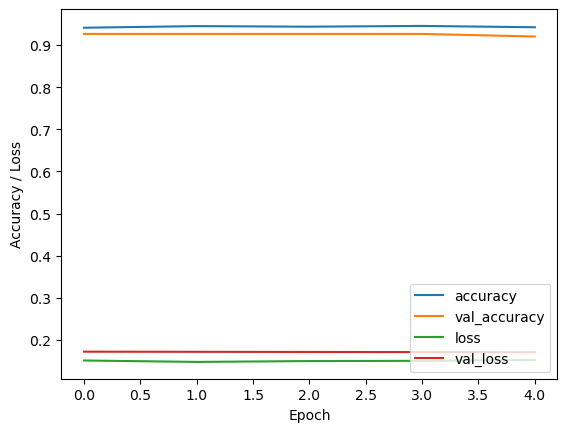

In [49]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(loaded_model_history)

### As we can see there is not much improvement in our val_accuracy . decrease in training loss indicates that model is not overfitting data . so we will stick to our previously loaded model for further evalution . 

In [51]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type = "Evaluation Log accuracy and loss",
    config = configs
)


In [54]:
model_path = 'model_accuracy:0.94_Val_acc:0.93_loss:0.16_Val_loss:0.17.keras'
loaded_best_model = load_model(model_path)

In [56]:
loss, accuracy = loaded_best_model.evaluate(test_dataset)
print('Test accuracy :', accuracy )
print("Test loss :" ,loss)
wandb.log({"Test accuracy":accuracy , "Test loss":loss})

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.9103 - loss: 0.2044
Test accuracy : 0.9285714030265808
Test loss : 0.19213160872459412


In [57]:
wandb.finish()

Not bad , 91% accuracy at test data set is still better .
so lets continue with this model and calculate confusion matrix and generate classification report .
But first lets have a look at some of test examples our model has evaluated .

In [58]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)



Predictions:
 [0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0]
Labels:
 [0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0]


In [59]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type = "Predictions image",
    config = configs
)

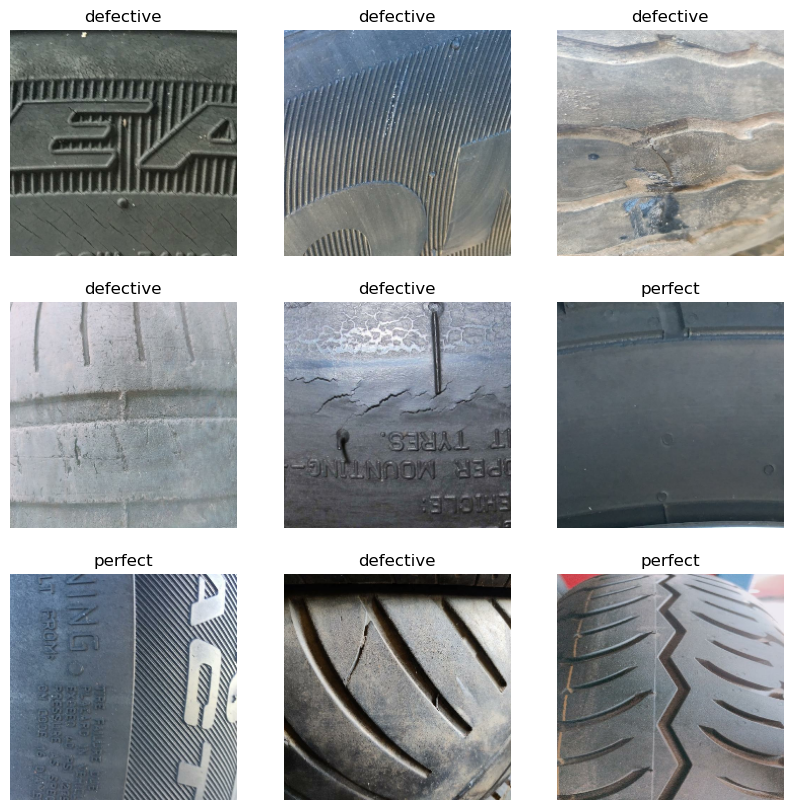

In [60]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(test_dataset_class_names[predictions[i]])
    plt.axis("off")
wandb.log({"img":[wandb.Image(plt,caption="Predictions on a batch")]})
    

In [61]:
wandb.finish()

In [62]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

In [63]:
# Initialize lists to accumulate predictions and labels
all_predictions = []
all_labels = []

# Iterate through the dataset
for image_batch, label_batch in test_dataset:
    predictions = model.predict_on_batch(image_batch).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    # Append current batch predictions and labels to the lists
    all_predictions.extend(predictions.numpy())
    all_labels.extend(label_batch.numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print or visualize predictions and labels
print('All Predictions:\n', all_predictions)
print('All Labels:\n', all_labels)


All Predictions:
 [0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1
 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
All Labels:
 [0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1
 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1
 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1
 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1]


2024-07-07 01:16:41.126753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
len(all_predictions),len(all_labels)

(182, 182)

In [65]:
type(all_predictions)

numpy.ndarray

In [66]:
cm = confusion_matrix(all_labels, all_predictions)
cm

array([[104,   1],
       [ 25,  52]])

In [67]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type = "Confusion matrix image",
    config = configs
)

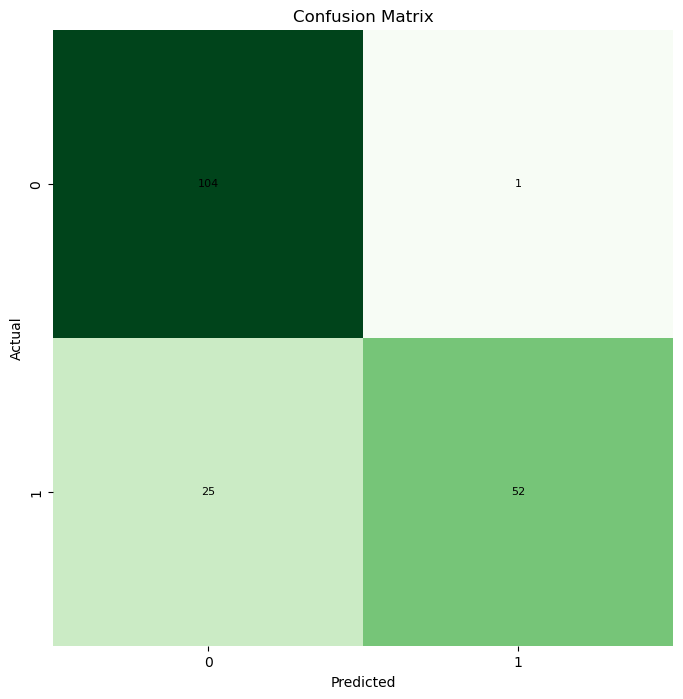

In [68]:
# Plot confusion matrix with annotations for all values
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add annotations for correct classifications
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}', ha='center', va='center', color='black', fontsize=8)
wandb.log({"img":[wandb.Image(plt,caption="Confusion Matrix")]})
plt.show()

In [69]:
wandb.finish()

In [70]:
# Initialize a W&B run
wandb.init(
    project = PROJECT,
    job_type = "Class classification logs",
    config = configs
)

In [76]:
#Calculate and print accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {accuracy:.2f}')
    wandb.log({f"{i}": str(accuracy)})
    

Accuracy for class 0: 0.99
Accuracy for class 1: 0.68


In [77]:
wandb.finish()

0,0.9904761904761905
1,0.6753246753246753


In [78]:
# Print classification report
print("Classification Report:")
calssification_report = classification_report(all_labels, all_predictions )

Classification Report:


In [79]:
type(calssification_report)

str

In [80]:
print(calssification_report)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       105
           1       0.98      0.68      0.80        77

    accuracy                           0.86       182
   macro avg       0.89      0.83      0.84       182
weighted avg       0.88      0.86      0.85       182



### Classification Model Performance Report

#### Overview
This report summarizes the performance of our classification model on a binary classification task. The model's performance has been evaluated using key metrics: precision, recall, F1-score, and support, which are detailed below for each class. Additionally, overall accuracy, macro average, and weighted average metrics are provided to give a comprehensive view of the model's performance.


- **Class 0** (Negative Class):
  - **Precision**: 81% of the instances predicted as Class 0 are correctly identified.
  - **Recall**: 99% of actual Class 0 instances are correctly identified.
  - **F1-Score**: The harmonic mean of precision and recall for Class 0 is 0.89.
  - **Support**: There are 105 actual instances of Class 0 in the dataset.

- **Class 1** (Positive Class):
  - **Precision**: 98% of the instances predicted as Class 1 are correctly identified.
  - **Recall**: 68% of actual Class 1 instances are correctly identified.
  - **F1-Score**: The harmonic mean of precision and recall for Class 1 is 0.80.
  - **Support**: There are 77 actual instances of Class 1 in the dataset.

#### Overall Metrics

- **Accuracy**: The model achieved an accuracy of 86%, indicating that 86% of the total predictions were correct.

- **Macro Average** (unweighted mean of metrics across classes):
  - **Precision**: 0.89
  - **Recall**: 0.83
  - **F1-Score**: 0.84

- **Weighted Average** (metrics weighted by the number of instances in each class):
  - **Precision**: 0.88
  - **Recall**: 0.86
  - **F1-Score**: 0.85

#### Interpretation

- **Class 0 Performance**: The model is highly effective at identifying Class 0 instances, with a near-perfect recall of 99%. This means that almost all true Class 0 instances are correctly identified. However, the precision is slightly lower at 81%, suggesting some instances are incorrectly classified as Class 0.

- **Class 1 Performance**: The model is very precise in identifying Class 1 instances, with a precision of 98%, meaning that when the model predicts Class 1, it is almost always correct. However, the recall for Class 1 is lower at 68%, indicating that a significant number of true Class 1 instances are not being identified by the model.

- **Overall Performance**: With an accuracy of 86%, the model performs well overall. The macro average and weighted average metrics show a balanced performance across both classes, with slightly higher precision and recall for Class 0 compared to Class 1.

#### Conclusion

The classification model demonstrates strong overall performance, particularly in identifying Class 0 instances. However, there is room for improvement in the recall for Class 1, which could be enhanced through further model tuning or by utilizing additional data. The model's high precision for Class 1 indicates that when it does predict this class, it is highly reliable.

This performance report provides a detailed overview of the model's strengths and areas for improvement, guiding future efforts to enhance classification accuracy and reliability.